In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
from pymol import cmd, CmdException

import os,time


def get_raw_distances(names='', state=1, selection='all', quiet=1):
    from chempy import cpv

    state, quiet = int(state), int(quiet)
    if state < 1:
        state = cmd.get_state()

    valid_names = cmd.get_names_of_type('object:measurement')
    if names == '':
        names = ' '.join(valid_names)
    else:
        for name in names.split():
            if name not in valid_names:
                print(' Error: no such distance object: ' + name)
                raise CmdException

    raw_objects = cmd.get_session(names, 1, 1, 0, 0)['names']

    xyz2idx = {}
    cmd.iterate_state(state, selection, 'xyz2idx[x,y,z] = (model,index)',space=locals())

    r = []
    for obj in raw_objects:
        try:
            points = obj[5][2][state - 1][1]
            if points is None:
                raise ValueError
        except (KeyError, ValueError, IndexError):
            continue
        for i in range(0, len(points), 6):
            xyz1 = tuple(points[i:i + 3])
            xyz2 = tuple(points[i + 3:i + 6])
            try:
                r.append((xyz2idx[xyz1], xyz2idx[xyz2], cpv.distance(xyz1, xyz2)))
                if not quiet:
                    print(' get_raw_distances: ' + str(r[-1]))
            except KeyError:
                if quiet < 0:
                    print(' Debug: no index for %s %s' % (xyz1, xyz2))
    return r

In [2]:
# import dataframe
overall_df = pd.read_csv("overall_results.csv")
overall_df.columns

Index(['index', 'name', 'EC number', 'sequence'], dtype='object')

In [3]:
# Calculate plddt
template_list_plddt = []
for index in overall_df["index"]:
    f_json = open("SPC_summary/%s/ranking_debug.json"%index,"r")
    json_dict = json.load(f_json)
    if [index,json_dict["plddts"]["model_1_ptm"],json_dict["plddts"]["model_2_ptm"]] not in template_list_plddt:
        template_list_plddt.append([index,json_dict["plddts"]["model_1_ptm"],json_dict["plddts"]["model_2_ptm"]])
template_df_plddt = pd.DataFrame(template_list_plddt,columns=["index","model_1_ptm_plddt","model_2_ptm_plddt"])
overall_df = overall_df.merge(template_df_plddt,how="left",on="index")

In [4]:
# Calculate protein properties
disul_list = []
hbond_list = []
sbrge_list = []
surf__list = []
sasa__list = []
sstrc_list = []
for i in range(overall_df.shape[0]):
    cmd.load("SPC_summary/%s/unrelaxed_model_1_ptm.pdb"%overall_df["index"][i],"%s_1"%overall_df["index"][i])   # load pdb file

    cmd.distance("disul","name SG","name SG",cutoff=2.1)     # disulfide bond
    cmd.distance("hbond","all","all",mode=2)                 # hydrogen bond
    cmd.distance("saltbridge","(resn ASP and name OD2) or (resn GLU and name OD2)","(resn ARG and (name NH1 or name NH2)) or (resn LYS and name NZ) or (resn HIS and name NE2)",cutoff=4)  # salt bridge
    cmd.dss()
    ss_string = ""
    for a in cmd.get_model(overall_df["index"][i] +" and n. ca").atom:
        ss_string = ss_string+a.ss 
    
    
    
    disul_list.append(len(get_raw_distances("disul")))       # disulfide bond
    hbond_list.append(len(get_raw_distances("hbond")))       # hydrogen bond
    sbrge_list.append(len(get_raw_distances("saltbridge")))  # salt bridge
    surf__list.append(cmd.get_area('all'))                   # protein surface
    cmd.set('dot_solvent',1)
    sasa__list.append(cmd.get_area('all'))                   # SASA
    sstrc_list.append(ss_string)                             # secondary structure


    cmd.reinitialize()
    print("\r%d/%d"%(i+1,overall_df.shape[0]),end="")


 PyMOL not running, entering library mode (experimental)
155/155

In [5]:
# Add calculated data to dataframe
overall_df["disulfide_bond"] = disul_list
overall_df["hydrogen_bond"] = hbond_list
overall_df["salt_bridge"] = sbrge_list
overall_df["surface"] = surf__list
overall_df["SASA"] = sasa__list
overall_df["secondary_structure"] = sstrc_list


In [6]:
overall_df.to_csv("total_results.csv",index=False)

In [10]:
# Calculate RMSD
index_total = overall_df.shape[0]
RMSDa_mat = np.zeros((index_total,index_total))
align_mat = np.zeros((index_total,index_total))


start_time = time.time()

for index in range(index_total):
    print("\rRMSD calculation of index: %d"%index,end="")
    protein_index = "SPC_%d"%(index+1)
    for index2 in range(index+1,index_total):
        protein_index2 = "SPC_%d"%(index2+1)
        cmd.load("SPC_summary/%s/unrelaxed_model_1_ptm.pdb"%protein_index,"Query")
        cmd.load("SPC_summary/%s/unrelaxed_model_1_ptm.pdb"%protein_index2,"Iterate")
        align_para = cmd.align("Query","Iterate",cycles=5)
        RMSDa_mat[index,index2] = align_para[0]
        RMSDa_mat[index2,index] = align_para[0]
        align_mat[index,index2] = align_para[1]
        align_mat[index2,index] = align_para[1]
        cmd.reinitialize()

end_time = time.time() - start_time
print("\nTotal timing: ",end_time)

RMSD calculation of index: 154
Total timing:  482.54947543144226


In [7]:
EC_list = ["1.2.7.11","2.7.2.3","4.2.1.11","1.2.1.59","5.3.1.1","5.4.2.12","2.7.1.40"]
overall_df["EC number"].value_counts()


1.2.7.11    31
4.2.1.11    24
2.7.2.3     24
1.2.1.59    22
5.3.1.1     21
5.4.2.12    19
2.7.1.40    14
Name: EC number, dtype: int64

In [8]:
first_index = overall_df[overall_df["EC number"] == "1.2.1.59"]["index"].values[0]
align_list = []
for index in overall_df[overall_df["EC number"] == "1.2.1.59"]["index"]:
    cmd.load("SPC_summary/%s/unrelaxed_model_1_ptm.pdb"%index,index)
    align_para = cmd.align(index,first_index,cycles=5)
    align_list.append(align_para)
cmd.cartoon("loop")
cmd.color("skyblue")
cmd.ray()
cmd.save("1.2.1.59.png")
cmd.reinitialize()


In [11]:
for EC_number in EC_list:
    first_index = overall_df[overall_df["EC number"] == EC_number]["index"].values[0]
    align_list = []
    for index in overall_df[overall_df["EC number"] == EC_number]["index"]:
        cmd.load("SPC_summary/%s/unrelaxed_model_1_ptm.pdb"%index,index)
        align_para = cmd.align(index,first_index,cycles=5)
        align_list.append(align_para)
    cmd.cartoon("loop")
    cmd.color("skyblue")
    cmd.ray()
    cmd.save("%s.png"%EC_number)
    cmd.reinitialize()

In [9]:
overall_df["name"].value_counts()


TACK_Korarchaeum_cryptofilum_OPF8_WP_012310248.1                         1
Thermodesulfobacteria_Thermodesulfatator_indicus_DSM_15286_AEH45865.1    1
Asgard_Ca_Prometheoarchaeum_syntrophicum_MKD1_QEE14264.1                 1
Eury_Ca_Hadesarchaea_archaeon_B3Hades_TKJ26909.1                         1
TACK_Korarchaeum_cryptofilum_OPF8_WP_012310111.1                         1
                                                                        ..
Asgard_Ca_Heimdallarchaeota_archaeon_B3Heim_PWI47748.1                   1
DPANN_Diapherotrites_CG_4_10_14_0_2_um_filter_31_5_PFQC01000198.1_2      1
Asgard_Ca_Prometheoarchaeum_syntrophicum_MKD1_QEE16088.1                 1
Fusobacteria_Leptotrichia_goodfellowii_DSM_19756_KI911785.1_41           1
Fusobacteria_Leptotrichia_goodfellowii_DSM_19756_KI911785.1_493          1
Name: name, Length: 155, dtype: int64

In [15]:
overall_df[overall_df["EC number"] == "1.2.1.59"].index

Int64Index([  1,   8,  18,  19,  25,  28,  37,  45,  54,  73,  79,  88,  96,
            105, 112, 117, 125, 130, 131, 139, 145, 151],
           dtype='int64')

Text(0.5, 1.0, 'RMSD: 1.2.1.59')

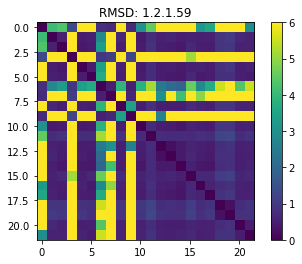

In [38]:
plt.imshow(RMSDa_mat[overall_df[overall_df["EC number"] == "1.2.1.59"].index][:,overall_df[overall_df["EC number"] == "1.2.1.59"].index],vmin=0,vmax=6)
plt.colorbar()
plt.title("RMSD: 1.2.1.59")

In [47]:
for EC_number in EC_list:
    plt.imshow(RMSDa_mat[overall_df[overall_df["EC number"] == EC_number].index][:,overall_df[overall_df["EC number"] == EC_number].index],vmin=0,vmax=6)
    plt.colorbar()
    plt.title("RMSD: %s"%EC_number)
    plt.savefig("RMSD_heat_%s.png"%EC_number)
    plt.close()

In [44]:
overall_df[overall_df["EC number"] == "1.2.1.59"].index

Int64Index([  1,   8,  18,  19,  25,  28,  37,  45,  54,  73,  79,  88,  96,
            105, 112, 117, 125, 130, 131, 139, 145, 151],
           dtype='int64')

In [49]:
index_list = ["SPC_2","SPC_20","SPC_38","SPC_46","SPC_74"]
align_list = []
for index in index_list:
    cmd.load("SPC_summary/%s/unrelaxed_model_1_ptm.pdb"%index,index)
    align_para = cmd.align(index,first_index,cycles=5)
    align_list.append(align_para)
cmd.cartoon("loop")
cmd.color("skyblue")
cmd.ray()
cmd.save("1.2.1.59_2.png")
cmd.reinitialize()


Text(0.5, 1.0, 'RMSD: 1.2.1.59')

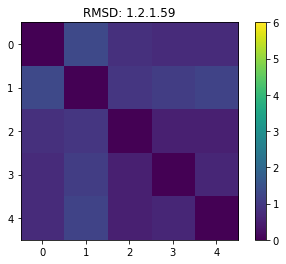

In [51]:
plt.imshow(RMSDa_mat[[1,19,37,45,73]][:,[1,19,37,45,73]],vmin=0,vmax=6)
plt.colorbar()
plt.title("RMSD: 1.2.1.59")